# 2D heat conduction over a 2D square domain using hard constraints


Works only on tf 1.x, 2.x and Pytorch

[An example: here](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.exactBC.html)

Backend supported: tensorflow.compat.v1, tensorflow, pytorch
 
 PDE: 
 $$u_{xx} + u_{yy} = 0, \qquad x\in [-0.5,0.5], \quad y \in [0,1]$$
 
 $$u(x,0) = u(x,1) = 0 \quad u(-0.5,y) = u(0.5,y) =1$$
 
The output transform with hard constraint would be:
 
$$u=\left(y-1\right)y $$ 

This equation exactly satisfies the BC no matter what garbage is predicted in the interior/collocation points.

* import packages
* define `dde.geometry.Interval` object for $x$.
* write a function for the residual.
* write a function to return boolean when `x` is a initial boundary point.
* Pass all the objects to `dde.data.PDE`
* define the neural network (architecture, activation, weight initialisation)
* build the model `dde.Model` by passing the data and network.
* initialise the optimiser
* train the model

For Pytorch: `nano ~/.deepxde/config.json`
then change `tensorflow.compat.v1` to `pytorch`


In [1]:
import deepxde as dde  # A complete problem: data+PDE+FCNN+optimiser
import numpy as np

Using backend: pytorch



In [3]:
#from deepxde.backend import torch # performs Pytorch operation on the dde object

In [2]:
# Parameters

#n=2
#precision_train = 10
#precision_test = 30
hard_constraint = False # set constraint type
weights = 100  # if hard_constraint == False

epochs = 5000
# learning rate, the number of dense layers and nodes, and the activation function
parameters = [1e-3, 8, 20, "tanh"]

# # Define sine function
# if dde.backend.backend_name == "pytorch":
#     sin = dde.backend.pytorch.sin
# else:
#     from deepxde.backend import tf

#     sin = tf.sin

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

In [3]:
def pde(X,u):
    """
    Returns the residual error

    Parameters
    ----------
    x : nd-array
        Independent variables.
    y : nd-array
        Dependent variables.

    Returns
    -------
    float
        The residual error.
    """ 
    dy_xx = dde.grad.hessian(u, X, i=0, j=0)
    dy_yy = dde.grad.hessian(u, X, i=1, j=1)
    
    #x = X[:, 0:1]
    #y = X[:, 1:2]
    #f = k0 ** 2 * sin(k0 * x) * sin(k0 * y)
    return dy_xx + dy_yy

# def boundary_r(x, on_boundary):
#     """
#     Defines the Periodic BC points (not the solution)
#     Returns 1 if x is on the boundary else 0.
#     because of rounding-off error we use np.isclose() to test whether two floating points are equivalent
#     """
#     return on_boundary
    
    
def boundary_left(X, on_boundary):
    """
    Defines the Dirichlet BC points (not the solution)
    The function should return `True` for those points inside the subdomain and `False` for the points outside.
    Returns 1 if x is on the boundary else 0.

    Parameters
    ----------
    x : 1d-array
        x,y,z coodinates of any point.

    Returns
    -------
    boolean
        whether x is on the boundary or not.
    """ 
    x = X[0]
    return on_boundary and np.isclose(x, -0.5) # when x= 0

def boundary_right(X, on_boundary):
    x = X[0] # # X[:, 0:1] is equivalent to X[:,0]
    return on_boundary and np.isclose(x, 0.5) # when x= 1

def boundary_bottom(X, on_boundary):
    y = X[1] # X[:, 1:2] is equivalent to X[:,1]
    return on_boundary and np.isclose(y, 0.0) # when y = 0

def boundary_top(X, on_boundary):
    y = X[1] # X[:, 1:2] is equivalent to X[:,1]
    return on_boundary and np.isclose(y, 1.0) # when y = 1

# def func_dirichlet(x):
#     """
#     Returns the prescribed Dirichlet boundary condition.
#     A wayaround is to use lambda function when specifying the BCs
#     Parameters
#     ----------
#     x : 1d-array
#         x,y,z coodinates of any point.
    
#     Returns
#     -------
#     float
#         the prescribed boundary condition at x.
    
#     Example
#     -------
#     If the function value is a constant
#     return 1
    
#     If the function value is not a constant
#         return np.sin(np.pi * x)
#     """ 
#     return 0


# def func_neumann(x):
#     """
#     Returns the prescribed Neumann boundary condition.
#     A wayaround is to use lambda function when specifying the BCs
#     Parameters
#     ----------
#     x : 1d-array
#         x,y,z coodinates of any point.
    
#     Returns
#     -------
#     float
#         the prescribed boundary condition at x.
    
#     Example
#     -------
#     If the function value is a constant
#     return 1
    
#     If the function value is not a constant
#         return np.sin(np.pi * x)
#     """ 
#     return 4 # see the problem

# def exact(X):
#     """
#     Returns the exact solution
#     Parameters
#     ----------
#     x : 1d-array
#         x,y,z coodinates of any point.
    
#     Returns
#     -------
#     float
#         The exact solution.
#     """ 
#     #x = X[:, 0:1]
#     #y = X[:, 1:2]
#     # x[:,1:] and x[:,1:2] are the same for x of size [no_of_samples,2]
    
#     return 0 # do not use tf.sin as this is just to plot the curve

If boundary conditions are enforced in a hard fashion, we apply the following transformation to the neural network:
$$\hat{u}(x,y) = x (x-1) y (y-1) \mathcal{N}(x,y)$$

In [4]:
# def transform(X, u): # transform the NN
#     x = X[:, 0:1]
#     y = X[:, 1:2]
#     res = x * (1 - x) * y * (1 - y)
#     return res * u

`dde.geometry.Rectangle` takes coordinates of bottom left and top right as input and creates a Rectangle.

We use a collocation points density of 10 (for test 30) points per wavelength for the training (resp. testing) data along each direction.

In [5]:
geom = dde.geometry.Rectangle(xmin=[-0.5,0.0], xmax=[0.5, 1.0]) # geometry

# # use lambda function to define the BC solution at each boundary
bc_left = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_left) # BC(boundary) 
bc_right = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_right ) # BC(boundary) 
# bc_bottom = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom ) # BC(boundary) 
# bc_top = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_top ) # BC(boundary) 

# bc_rad = dde.icbc.DirichletBC(geom,
#                              lambda x: np.cos(x[:, 1:2]), # remember x[:, 1:2] is theta
#                              boundary_l,
#                              # the same can be implemented as
#                             # lambda x, on_boundary: on_boundary and np.isclose(x[0], 1),                 
#                                 )

#bc_l = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l) # BC (dirichlet)
#bc_r = dde.icbc.PeriodicBC(geom, 0, boundary_r) # Periodic condition
# Example: bc_r = dde.icbc.NeumannBC(geom, lambda X: 2*(X+1), boundary_r)
# bc_r = dde.icbc.NeumannBC(geom, 4, boundary_r) will give error as int is not callable 

# 1200: no. of collocation points
# 120: no. of BC points
# num_test: no residual points for testing
# For hard constraint we exclude the BCs in the loss function
data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right],
    #[bc_left, bc_right, bc_bottom, bc_top],
    num_domain = 3500,
    num_boundary = 400, # the BC are prescribed on 2D domain so we have lot more points
    #solution = exact, # we don't know the exact solution
    #num_test = nx_test ** 2
)

/home/s.1915438/.conda/envs/ml/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+404=404. 
  warnings.warn("The balance properties of Sobol' points require "


The argument `solution=exact` is the reference solution to compute the error of our solution, 
and can be ignored if we don’t have a reference solution.

In [6]:
#layer_size = [2] + [20]*3 + [1] # [1, 50, 50, 50, 1]
#activation = "tanh"
#initialiser = "Glorot normal"
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    "Glorot uniform"
) # creating a neural network

# Apply the feature transform
#net.apply_feature_transform(feature_transform)

When soft constraints are applied, we apply a weight to the boundary term to improve convergence for the ADAM optimizer.

In [7]:
# hard constraint expression
# An example: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.exactBC.html

def transform(X, u): # transform the NN
    x = X[:, 0:1]
    y = X[:, 1:2]
    res = (y-1) * y
    return res * u

net.apply_output_transform(transform)

#net.apply_output_transform(
#    lambda X, u: (X[:, 0:1] - 0.5) * (X[:, 0:1] + 0.5) * (X[:, 1:2]-1) * X[:, 1:2]*u
    #lambda X, u: X[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
#)

In [8]:
# if hard_constraint == True: # transform the NN
#     net.apply_output_transform(transform)

model = dde.Model(data, net)  # defining the model

# if hard_constraint == True:
#     model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
# else:
#     loss_weights = [1, weights] # soft contraint
#     model.compile(
#         "adam",
#         lr=learning_rate,
#         metrics=["l2 relative error"],
#         loss_weights=loss_weights,)

model.compile("adam",
              lr=1e-3,
              #metrics=["l2 relative error"], # we don't have the testing dataset (true solution)
            ) # setting the optimiser

Compiling model...
'compile' took 0.000329 s



In [17]:
# Training with Adam
losshistory, train_state = model.train(epochs=epochs, model_save_path="model/model.ckpt")

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [3.09e-03, 1.73e-01, 1.78e-01]    [3.09e-03, 1.73e-01, 1.78e-01]    []  
6000      [3.56e-03, 1.67e-01, 1.77e-01]    [3.56e-03, 1.67e-01, 1.77e-01]    []  
7000      [5.66e-03, 1.55e-01, 1.75e-01]    [5.66e-03, 1.55e-01, 1.75e-01]    []  
8000      [6.02e-03, 1.35e-01, 1.74e-01]    [6.02e-03, 1.35e-01, 1.74e-01]    []  
9000      [1.33e-02, 1.22e-01, 1.72e-01]    [1.33e-02, 1.22e-01, 1.72e-01]    []  
10000     [3.73e-02, 1.15e-01, 1.70e-01]    [3.73e-02, 1.15e-01, 1.70e-01]    []  

Best model at step 9000:
  train loss: 3.08e-01
  test loss: 3.08e-01
  test metric: []

Epoch 10000: saving model to model/model.ckpt-10000.pt ...

'train' took 87.966469 s



In [18]:
# Optional: Save the model during training.
checkpointer = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", verbose=1, save_better_only=True
)


In [19]:
# save all the variables
model.save('model',protocol='backend', verbose=0)

'model-10000.pt'

In [ ]:
# Optional: Save the movie of the network solution during training.
# ImageMagick (https://imagemagick.org/) is required to generate the movie.
movie = dde.callbacks.MovieDumper(
    "model/movie", [-1], [1], period=100, save_spectrum=True, y_reference=func
)
losshistory, train_state = model.train(epochs=10000, callbacks=[checkpointer, movie])


Saving loss history to /scratch/s.1915438/temp/5. 2D heat conduction Deepxde_hard constraint/1. Constant temperature/loss.dat ...
Saving training data to /scratch/s.1915438/temp/5. 2D heat conduction Deepxde_hard constraint/1. Constant temperature/train.dat ...
Saving test data to /scratch/s.1915438/temp/5. 2D heat conduction Deepxde_hard constraint/1. Constant temperature/test.dat ...


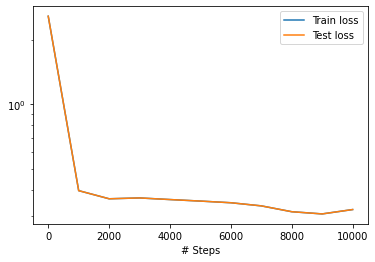

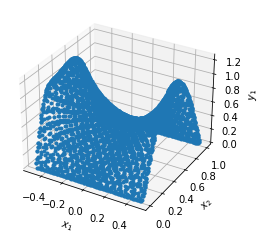

In [20]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

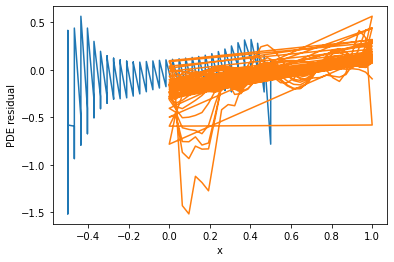

In [21]:
# Optional: Restore the saved model with the smallest training loss
# model.restore(f"model/model-{train_state.best_step}.ckpt", verbose=1)
# Plot PDE residual
import matplotlib.pyplot as plt
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()

In [22]:
# Custom plot
# Link: https://github.com/lululxvi/deepxde/issues/17
# In test.dat, the first column is x coordinate, the second column is y coordinate, the 3rd column is y_true, the 4th column is y_pred.
import numpy as np
data = np.genfromtxt('test.dat')

In [23]:
x, y, y_pred = data[:,0], data[:,1], data[:,2]

/tmp/ipykernel_11328/698679839.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  sc1.cmap.set_under('k')
/tmp/ipykernel_11328/698679839.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("jet").copy()
  sc1.cmap.set_over('k')


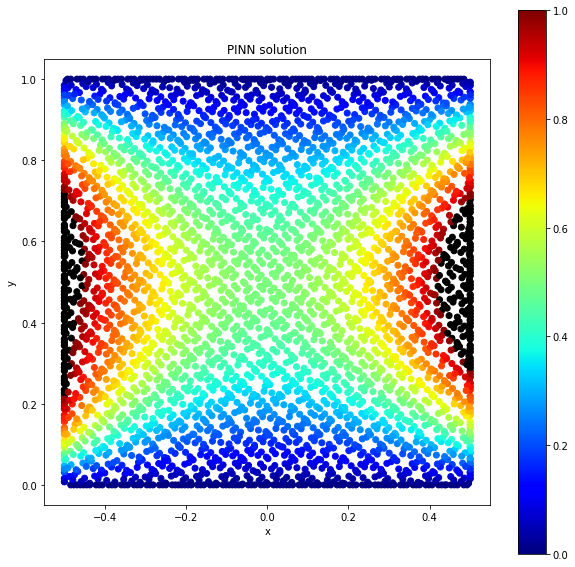

In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
#plt.figure(1,figsize=(12,10))
fig, ax = plt.subplots(1,figsize=(10,10))
sc1 = ax.scatter(x,y, c = y_pred, cmap=cm.jet, vmin=0.0, vmax=1.0)
sc1.cmap.set_under('k')
sc1.cmap.set_over('k')
ax.set_title('PINN solution')
ax.set_aspect('equal', 'box')
# sc2 = ax[1].scatter(x,y, c = y_pred, cmap=cm.jet)
# ax[1].set_title('Predicted Solution')
# ax[1].set_aspect('equal', 'box')
# sc3 = ax[2].scatter(x,y, c = abs(y_pred-y_true), cmap=cm.jet)
# ax[2].set_title('Absolute pointwise error')
# ax[2].set_aspect('equal', 'box')


#for axs in ax.flat:
ax.set(xlabel='x', ylabel='y')
fig.colorbar(sc1, ax=ax)
#fig.colorbar(sc2, ax=ax[1])
#fig.colorbar(sc3, ax=ax[2])
#plt.savefig('Solution_with_bounds.jpg', dpi = 200)